## Image Denoiser using [DeepInverse](https://github.com/deepinv/deepinv)

> The current notebook is part of [AI Image Editing and Manipulation](https://github.com/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/) pipeline from [**Computer Vision Challenge**](https://github.com/afondiel/computer-vision-challenge).

<img width="400" height="400" src="https://github.com/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/docs/pipeline-last.png?raw=true">


|--|Notebook|Demo (Gradio)|
|--|--|--|
||[![Open notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/notebooks/Denoiser_Deepinv.ipynb)|[HF Space (Ongoing)](https://huggingface.co/spaces)|

### Install Dependencies

In [1]:
# Installs the necessary dependencies for image denoising using Deep Inverse.

!pip install accelerate transformers gradio datasets -U
!pip install torch torchvision torchaudio fastai timm -U
!pip install deepinv gradio_imageslider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10

### Import Libraries

In [36]:
import os
import numpy as np
import torch
import torchvision
import deepinv as dinv
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from datasets import load_dataset
import gradio as gr
from gradio_imageslider import ImageSlider


### Preprocessing & Transformation

In [37]:
# Dictionary mapping model names to their corresponding functions
model_dict = {
  "DnCNN": dinv.models.DnCNN,
  "DRUNet": dinv.models.DRUNet,
  "GSDRUNet": dinv.models.GSDRUNet,
  "SCUNet": dinv.models.SCUNet,
  "SwinIR": dinv.models.SwinIR,
  "DiffUNet": dinv.models.DiffUNet,
  # "EPLL": dinv.models.EPLL,
  "Restormer": dinv.models.Restormer
}

# Function to load a dataset from Hugging Face
def load_hf_dataset(dataset_name="afondiel/dummy_images"):
    """
    Loads a dataset from Hugging Face.

    Args:
        dataset_name (str): The name of the dataset to load.

    Returns:
        DatasetDict: A dictionary containing the loaded dataset.
    """
    return load_dataset(dataset_name)

# Function to extract and preprocess images
def preprocess_images_from_dataset(dataset):
    """
    Extracts and preprocesses images from a dataset.

    Args:
        dataset (DatasetDict): The dataset containing images.

    Returns:
        list: A list of preprocessed images as PyTorch tensors.
    """
    image_list = []
    for example in dataset['test']:
        img = extract_image_from_example(example)
        img_tensor = preprocess_image(img)
        image_list.append(img_tensor)

    return image_list

# Function to extract image from example
def extract_image_from_example(example):
    """
    Extracts an image from a dataset example.

    Args:
        example (dict): A dictionary representing a single dataset example.

    Returns:
        PIL.Image.Image: The extracted image.
    """
    im = example['image']
    if isinstance(im, str):
        img = Image.open(im)
    elif isinstance(im, dict):
        img = Image.open(BytesIO(requests.get(im['path']).content))
    elif isinstance(im, Image.Image):
        img = im
    else:
        raise ValueError("Invalid image format")
    return img

# Function to preprocess an image
def preprocess_image(image):
    """
    Preprocesses an image for model input.

    Args:
        image (PIL.Image.Image): The image to preprocess.

    Returns:
        torch.Tensor: The preprocessed image as a PyTorch tensor.
    """
    image = image.convert("RGB")
    image = image.resize((256, 256))
    image = np.array(image).astype(np.float32) / 255.0
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
    return image_tensor

# Function to convert tensor to PIL image for display
def tensor_to_pil_image(image_tensor):
    """
    Converts a PyTorch tensor to a PIL image.

    Args:
        image_tensor (torch.Tensor): The image tensor.

    Returns:
        PIL.Image.Image: The converted PIL image.
    """
    image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    return Image.fromarray(image)

# Function to display images
def display_image(image, title="Image"):
    """
    Displays an image using matplotlib.

    Args:
        image (PIL.Image.Image): The image to display.
        title (str): The title of the image.
    """
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to display images
def display_images(input_img, sr_img):
    """
    Displays the original and super-resolved images side by side.

    Args:
        input_img (np.array): The original input image.
        sr_img (np.array): The super-resolved image.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(input_img)
    plt.subplot(1, 2, 2)
    plt.title('Denoised Image')
    plt.imshow(sr_img)
    plt.show()

### **Denoiser: DeepInverse**

The DeepInverse has a family of [Denoiser Models](https://deepinv.github.io/deepinv/deepinv.denoisers.html) with [pretrained Weights](https://deepinv.github.io/deepinv/deepinv.denoisers.html#pretrained-weights):


| **Model**          | **Weight Details**                                                              | **Pretrained Weights**                                                                                   |
|-------------------|----------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| `DnCNN`           | Noise level 2.0/255, grayscale & color                                           | [Grayscale](https://huggingface.co/juglab/dncnn), [Color](https://huggingface.co/juglab/dncnn-color)     |
| `DRUNet`          | Noise levels [0, 20]/255, grayscale & color                                      | [Grayscale](https://huggingface.co/juglab/drunet), [Color](https://huggingface.co/juglab/drunet-color)   |
| `GSDRUNet`        | Noise levels [0, 50]/255, color                                                  | [Color](https://huggingface.co/juglab/gsdrunet)                                                          |
| `SCUNet`          | Synthetic noise & camera artifacts                                               | [Color](https://huggingface.co/juglab/scunet)                                                            |
| `SwinIR`          | Noise levels {15, 25, 50}/255, grayscale & color                                 | [Weights](https://github.com/juglab/swinir)                                                              |
| `DiffUNet`        | FFHQ and ImageNet128, various hidden channels                                    | [FFHQ](https://huggingface.co/deepinv/diffunet-ffhq), [ImageNet128](https://huggingface.co/deepinv/diffunet-imagenet128) |
| `EPLL`            | Parameters from BSDS500 patches for grayscale & color images                     | [Weights](https://huggingface.co/deepinv/epll)                                                            |
| `Restormer`       | Efficient Transformer for High-Resolution Image Restoration                      | [Pretrained](https://huggingface.co/deepinv/restormer), [GitHub](https://github.com/swz30/Restormer)     |

For more details, visit the [DeepInv Denoisers page](https://deepinv.github.io/deepinv/deepinv.denoisers.html#pretrained-weights).


In [38]:
def denoise_image(image_tensor, selected_model="DRUNet", sigma=0.1):
    """
    Denoises an image using a pre-trained model.

    Args:
        image_tensor (torch.Tensor): The input image as a tensor.
        selected_model (str): The selected model name from the dictionary.
        sigma (float): The noise level.

    Returns:
        torch.Tensor: The denoised image as a tensor.
    """

    # Check if CUDA is available and set the device accordingly
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    # Load the selected model
    model_class = model_dict.get(selected_model, dinv.models.DRUNet)
    # model = model_class().cuda()
    model = model_class().to(device)

    # image_tensor = image_tensor.cuda()
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        denoised_image = model(image_tensor, sigma)
    return denoised_image


Using device: cpu


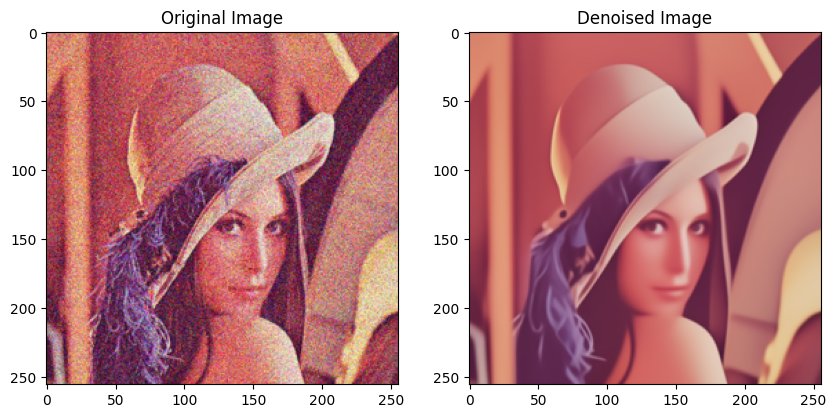

In [39]:
# ---------------------------------------------------
# Main: running the App
# ---------------------------------------------------

# Run the main function
if __name__ == "__main__":
  """
  Denoising process:
  1. Load the dataset
  2. Preprocess images
  3. Perform denoising
  4. Convert the denoised tensor to PIL image and display
  """
  # Load the dataset
  dataset = load_hf_dataset("afondiel/dummy_images")

  # Preprocess images
  images = preprocess_images_from_dataset(dataset)
  # Select a random image
  noisy_image = images[3]

  # Perform denoising using a selected model (e.g., "DnCNN")
  selected_model = "DRUNet" #@param ["DnCNN", "DRUNet", "GSDRUNet", "SCUNet", "SwinIR", "DiffUNet", "EPLL", "Restormer"] {type:"raw"}
  sigma = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}
  denoised_image = denoise_image(noisy_image, selected_model, sigma)

  # Visualization
  # Convert the noisy image tensor to a PIL image
  noisy_pil_image = tensor_to_pil_image(noisy_image)
  # Convert the denoised tensor to PIL image and display
  denoised_pil_image = tensor_to_pil_image(denoised_image)
  # Display the images, using the PIL images
  display_images(noisy_pil_image, denoised_pil_image)


### App Demo with Gradio

In [42]:
def launch_gradio_demo():
    def denoise_with_gradio(image, selected_model, sigma):
        # Preprocess image
        image_tensor = preprocess_image(image)

        # Perform denoising with the selected model
        denoised_image_tensor = denoise_image(image_tensor, selected_model, sigma)

        # Convert tensors to PIL images
        denoised_image = tensor_to_pil_image(denoised_image_tensor)

        return [image, denoised_image]

    # Gradio Interface
    demo = gr.Interface(
        fn=denoise_with_gradio,
        inputs=[
            gr.Image(type="pil"),
            # gr.Radio(
            #     list(model_dict.keys()),
            #     label="Select Model",
            #     value="DRUNet"
            # )
            gr.Dropdown(
                list(model_dict.keys()),
                label="Select Denoiser Model",
                value="DRUNet"
            ),
            gr.Slider(0.01, 1.0, step=0.01, label="Sigma (Noise Level)", value=0.1),
        ],
        outputs=ImageSlider(),
        title="AI Image Denoiser",
        description="Upload an image and select a denoising model to see the result side-by-side.",
        examples=[[tensor_to_pil_image(images[3])]],
        # article="""
        # """,
        # allow_flagging="never",
    )

    demo.launch(share=True)


In [43]:
# launch demo
launch_gradio_demo()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://01a08afc6e22afed43.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## References


**Docs:**

- [DeepInverse Doc](https://deepinv.github.io/deepinv/)
- [DeepInverse Doc - Pretrained Weights](https://deepinv.github.io/deepinv/deepinv.denoisers.html#pretrained-weights/)

- *Denoising:*
  - [Brief review of image denoising techniques](https://vciba.springeropen.com/articles/10.1186/s42492-019-0016-7)
  - [Denoising Techniques - Basics](https://iq.opengenus.org/image-denoising-and-image-processing-techniques/)
  - [Methods for image denoising using **CNN** - 2021](https://d-nb.info/1242356061/34)

  - [Denoising Diffusion Probabilistic Models (DDPM)](https://huggingface.co/docs/diffusers/v0.17.1/api/schedulers/ddpm)
    - paper: https://arxiv.org/pdf/2010.02502

**Datasets:**
- https://paperswithcode.com/datasets?task=image-denoising

**Models:**

Resnet
- [Resnet18 paper - Deep Residual Learning for Image Recognition: @Microsoft Research](https://arxiv.org/pdf/1512.03385)
- [U-Net Explained - paper with Code](https://paperswithcode.com/method/u-net)

Real-ESRGAN:
- Paper: [Real-ESRGAN: Training Real-World Blind Super-Resolution with Pure Synthetic Data](https://arxiv.org/pdf/2107.10833)
- [HF Space](https://huggingface.co/spaces/akhaliq/Real-ESRGAN)

ESRGAN:

[Enhanced Super-Resolution Generative Adversarial Networks - paper 2018](https://arxiv.org/pdf/1809.00219)

**BENCHMARKING:**

- Popular Denoising Datasets:
  - BSD500, Set12, Urban100, DIV2K (Diverse 2K), KODAK, DND (Darmstadt Noise Dataset)...
  - [Full list](https://paperswithcode.com/datasets?task=image-denoising)
- SOTA Denoising Models: DnCNN, FFDNet, MemNet, RED-Net, VDN, Noise2Noise, BM3D, WNNM, SwinIR, NAFNet, [DDPM](https://hojonathanho.github.io/diffusion/)
  - Please refer to this [Benchmarking](https://github.com/afondiel/computer-vision-challenge/blob/main/L2_03_AI_Powered_Image_Restoration_and_Enhancement/docs/Image_Restoration_Enhancement_Model_Benchmark.md) to see the top SOTA models for denoising tasks.


